In [1]:
import importlib
import numpy as np
from sklearn.metrics import confusion_matrix
import time

from helpers import pre_processing_wlan_utils as preprocess_utils
from helpers import classifier_wlan_spectral_utils as classifier_utils

/home/mcamelo/anaconda3/envs/traffic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mcamelo/anaconda3/envs/traffic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mcamelo/anaconda3/envs/traffic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mcamelo/anaconda3/envs/traffic/lib

In [2]:
seed = 42
task = "app-type"
label = preprocess_utils.label_index[task]
num_classes = preprocess_utils.num_classes[task]
num_classes = 3
print("Label id: ", label)
print("Num classes in that label: ", num_classes)
iq_seqs = [10000]
padding = 'post'
dataset_folder = '../../dataset/waveforms/'
prefix_file_name = 'wlan_classifier_'+str(num_classes)+"_classes_"+task+'_'
load_model=False
load_dir='../../models/'
load_file = '22042020175144_saved_wavenet_classifier'

Label id:  2
Num classes in that label:  3


In [3]:
prefix_file_name = '16042020_wlan_classifier_'+str(num_classes)+"_classes_"+task+'_'
dataset_filename = 'waveforms_16042020_2G_n_6_mobile_app_reduced_app-type_3_classes_balanced.mat'
#X, Y = utils.get_xy(dataset_folder,dataset_filename, num_iq_seq, padding, label, num_classes)
Xraw, Yraw = classifier_utils.get_raw_xy(dataset_folder,dataset_filename)

100%|██████████| 126198/126198 [02:36<00:00, 806.84it/s]


In [4]:
importlib.reload(preprocess_utils)
importlib.reload(classifier_utils)
kernel_size = 2
dilation_depth = 6
n_filters = 50

In [5]:
acc_results=[]
for num_iq_seq in iq_seqs:
    print("Padding/Truncating sequence")
    time.sleep(2)
    X = classifier_utils.pad_or_trunc_x_and_scale(Xraw, num_iq_seq, padding, scale=False)
    print("Oneshot labels")
    time.sleep(2)
    Y = classifier_utils.get_one_shot_labels(Yraw, num_classes, label)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = classifier_utils.get_xy_4_training(X,Y,seed)
    print(X_train.shape,X_val.shape, X_test.shape)
    print(Y_train.shape,Y_val.shape, Y_test.shape)
    print(X_train[:,1])
    wnc = classifier_utils.WaveNetClassifier((2,num_iq_seq), (num_classes,), kernel_size = 2, dilation_depth = dilation_depth, n_filters = n_filters, prefix = prefix_file_name)
    history = wnc.fit(X_train, Y_train, validation_data = (X_val, Y_val),save=True, epochs = 50)
    test_results = wnc.evaluate(X_test, Y_test)
    acc_results.append(test_results)
    print(num_iq_seq, test_results)

Padding/Truncating sequence


100%|██████████| 126198/126198 [00:11<00:00, 10521.85it/s]


Oneshot labels
(88338, 2, 10000) (18930, 2, 10000) (18930, 2, 10000)
(88338, 3) (18930, 3) (18930, 3)
[[ 9467   239 -8019 ...     0     0     0]
 [ 1140   234 -7863 ...     0     0     0]
 [ 9327   235 -7901 ...     0     0     0]
 ...
 [  450   239 -8010 ...     0     0     0]
 [ 5485   228 -7646 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


Train on 88338 samples, validate on 18930 samples
Epoch 1/50
88338/88338 [==============================] - 707s 8ms/step - loss: 0.4011 - accuracy: 0.8369 - val_loss: 0.2992 - val_accuracy: 0.8911

Epoch 00001: val_loss improved from inf to 0.29923, saving model to ./04052020135404_16042020_wlan_classifier_3_classes_app-type__wavenet_classifier.h5
Epoch 2/50
88338/88338 [==============================] - 699s 8ms/step - loss: 0.2868 - accuracy: 0.8980 - val_loss: 0.2640 - val_accuracy: 0.9085

Epoch 00002: val_loss improved from 0.29923 to 0.26395, saving model to ./04052020135404_16042020_wlan_classifier_3_classes_app-type

In [6]:
acc_results

[[0.1606309775599587, 0.9348124861717224]]

In [7]:
test_results = wnc.evaluate(X_test, Y_test)

18930/18930 [==============================] - 40s 2ms/step


In [8]:
print(test_results)

[0.1606309775599587, 0.9348124861717224]


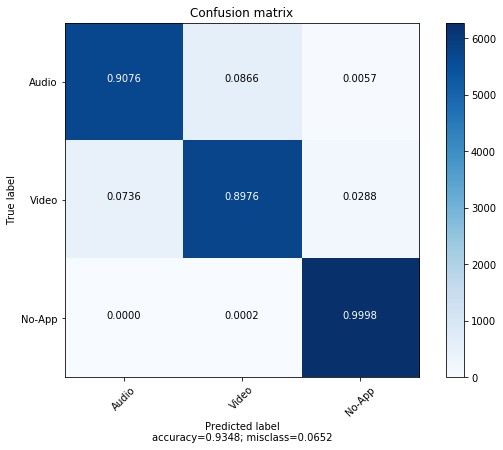

In [19]:
Y_pred_test=np.argmax(wnc.predict(X_test),1)
Y_true_test=np.argmax(Y_test,1)
classifier_utils.plot_confusion_matrix_mc(Y_true_test, Y_pred_test, ["Audio", "Video", "No-App"], "conf_matrix_test_app.pdf")

In [9]:
dataset_filename = 'waveforms_16042020_2G_n_6_mobile_app_reduced_app-type_3_classes_balanced.mat'
Xraw_test2, Yraw_test2 = classifier_utils.get_raw_xy(dataset_folder,dataset_filename)

100%|██████████| 126198/126198 [02:58<00:00, 706.24it/s]


In [10]:
X_test2 = classifier_utils.pad_or_trunc_x_and_scale(Xraw_test2, num_iq_seq, padding, scale=False)
Y_test2 = classifier_utils.get_one_shot_labels(Yraw_test2, num_classes, label)
    

100%|██████████| 126198/126198 [04:57<00:00, 424.65it/s]


In [11]:
test_results_2 = wnc.evaluate(X_test2, Y_test2)

126198/126198 [==============================] - 290s 2ms/step


In [12]:
print(test_results_2)

[0.15938984188417318, 0.9360607862472534]


In [14]:
dataset_filename = 'waveforms_24042020_2G_n_6_mobile_app_full_app-type_3_classes_balanced.mat'
Xraw_test3, Yraw_test3 = classifier_utils.get_raw_xy(dataset_folder,dataset_filename)

100%|██████████| 126834/126834 [06:47<00:00, 310.92it/s]


In [15]:
X_test3 = classifier_utils.pad_or_trunc_x_and_scale(Xraw_test3, num_iq_seq, padding, scale=False)
Y_test3 = classifier_utils.get_one_shot_labels(Yraw_test3, num_classes, label)

100%|██████████| 126834/126834 [10:12<00:00, 206.91it/s]


In [16]:
test_results_3 = wnc.evaluate(X_test3, Y_test3)
print(test_results_3)

126834/126834 [==============================] - 357s 3ms/step
[0.7039654443930788, 0.7935647964477539]


In [17]:
Y_pred_3=np.argmax(wnc.predict(X_test3),1)
Y_true_3=np.argmax(Y_test3,1)

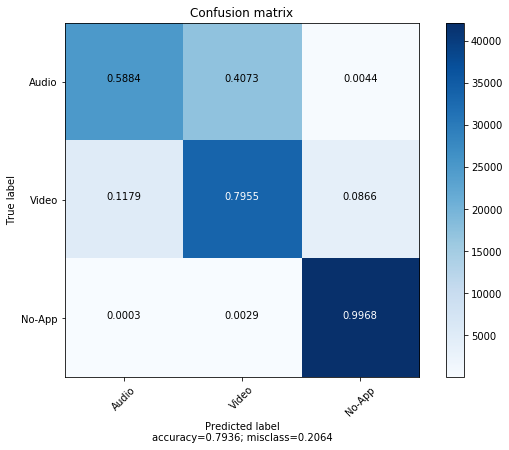

In [18]:
classifier_utils.plot_confusion_matrix_mc(Y_true_3, Y_pred_3, ["Audio", "Video", "No-App"], "conf_matrix_test3_app.pdf")